In [318]:
import numpy as np
from numpy import log
import matplotlib.pyplot as plt  
%matplotlib inline
import scipy.optimize as optimize

import scipy.io
import random

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier


In [319]:
def addOnes(X):
    m = X.shape[0]
    ones = np.ones(m)
    onesX = np.column_stack((ones, X))
    return onesX

def subOnes(X):
    return X[:,1:]

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def initTheta(n, option=0):
    theta= np.zeros(n)
    if option != 0:
        theta = np.random.random(n)
    return theta.reshape(-1,1)

def computeCost(theta, X, y, lamda = 0):
    X = addOnes(X)
    m = X.shape[0]
    theta = theta.reshape(-1,1)
    theta0 = np.copy(theta); theta0[0] = 0
    y = y.reshape(-1,1)
    h = X @ theta
    J = np.sum((h - y) ** 2) + lamda * np.sum(theta0 ** 2)
    J = J / (2. * m)
    return J

def computeCost2(X, y, theta0, theta1):
    m = X.shape[0]
    J = np.zeros((theta0.size, theta1.size))
    for i in range(theta0.size):
        for j in range(theta1.size):
            theta = np.array([[theta0[i]], [theta1[j]]])
            J[i,j] = computeCost(theta, X, y)
    return J

def computeGrad(theta, X, y, lamda = 0):
    X = addOnes(X)
    m = X.shape[0]
    theta = theta.reshape(-1,1)
    theta0 = np.copy(theta); theta0[0] = 0
    y = y.reshape(-1,1)
    grad = np.zeros(len(theta))
    h = X @ theta
    grad = X.T @ (X.dot(theta) - y) + lamda * theta0
    grad = grad / (1.* m)
    grad = grad.ravel()
    return grad

def trainLinReg(X, y, lamda=0):
    initial_theta = initTheta(X.shape[1] + 1)
    theta = optimize.fmin_l_bfgs_b(computeCost, initial_theta, args = (X, y,lamda),fprime=computeGrad)[0]
    return theta

def computeCostLog(theta, X, y, lamda = 0):
    m = X.shape[0]
    theta = theta.reshape(-1,1)
    t0 = np.copy(theta); t0[0] = 0;
    y = y.reshape(-1,1)
    h = sigmoid(X @ theta)
    J =  - y.T @ log(h) - (1- y).T @ log(1-h) + (lamda/2) * t0.T @ t0
    J = (1.0/m) * J
    return J[0,0]

def computeGradLog(theta, X, y, lamda = 0):
    m = X.shape[0]
    theta = theta.reshape(-1,1)
    t0 = np.copy(theta); t0[0] = 0;
    y = y.reshape(-1,1)
    h = sigmoid(X @ theta)
    grad = (1.0/m) * (X.T @ (h - y)) + lamda * t0
    grad = grad.ravel()
    return grad

def gradientDescentLog(X, y, lamda=0, alpha = 0.01, numIter = 1500):
    m = X.shape[0]
    n = X.shape[1]
    theta = np.zeros((n, 1))
    y = y.reshape(-1,1)
    J = np.zeros(numIter)
    for i in range(0, numIter):
        h = sigmoid(X @ theta)
        t0 = np.copy(theta); to[0] = 0;
        cost =  (1.0/m) * (- y.T @ log(h) - (1- y).T @ log(1-h)) + (lamda/2) * t0.T @ t0
        J[i] = cost[0]

        gradient =  (1.0/m) * (X.T @ (h - y)) + lamda * t0
        theta = theta - alpha * gradient
    theta = theta.ravel()
    return (theta, J[-1], J)

def predict(theta, X):
    h = sigmoid(X @ theta)
    threshold = 0.5
    predict = (h > threshold).astype(int)
    return predict

def accuracy(theta, X, y):
    p = predict(theta, X)
    compare = (p.reshape(1,-1) == y.reshape(1,-1)).astype(int)
    accuracy = np.mean(compare)
    return accuracy


def learningCurve(X, y, Xval, yval, lamda=0.):
    m = X.shape[0]
    
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    for i in range(m):
        X_sub = X[:i+1]
        y_sub = y[:i+1]
        
        theta = trainLinReg(X_sub, y_sub, lamda)
        error_train[i] = computeCost(theta, X_sub, y_sub)
        error_val[i] = computeCost(theta, Xval, yval)
    return (error_train, error_val)

def validationCurve(X, y, Xval, yval, lamda_vec=np.logspace(-2,2,20)):
    n = len(lamda_vec)
    error_train = np.zeros(n)
    error_val = np.zeros(n)
    
    for i in range(n):
        lamda = lamda_vec[i];
        theta = trainLinReg(X, y, lamda)
        error_train[i] = computeCost(theta, X, y, lamda)
        error_val[i] = computeCost(theta, Xval, yval, lamda)
    
    return (error_train, error_val)

def plotData(theta, X, y):
    x_lin = np.linspace(np.min(X) - 1, np.max(X) + 1, 100); x_lin.shape
    plt.scatter(X,y, color='r', marker='x', alpha=.4)
    plt.ylabel('y')
    plt.xlabel('X')
    plt.plot(x_lin, addOnes(x_lin) @ theta)
    plt.show()
    
def plotDataLin(X, y):
    initial_theta = initTheta(X.shape[1] + 1)
    theta = optimize.fmin_l_bfgs_b(computeCost, initial_theta, args = (X, y,),fprime=computeGrad)[0]
    plotData(theta, X, y)

def plotPoly(X, y, p, margin=5, lamda=0):
    X = X.reshape(-1,1)
    poly = PolynomialFeatures(p)
    X_poly = poly.fit_transform(X)
    X_poly = subOnes(X_poly)
    #scaler = StandardScaler().fit(X_poly)
    #X_poly = scaler.transform(X_poly)
    (X_poly,_,_) = featureNormalize(X_poly)
    theta = trainLinReg(X_poly, y, lamda=lamda)
    plt.scatter(X, y, marker='x', color='r')
    x_lin = np.linspace(np.min(X) - margin, np.max(X) + margin, 100).reshape(-1,1)
    x_lin_poly = poly.fit_transform(x_lin)
    x_lin_poly = scaler.transform(subOnes(x_lin_poly))
    plt.plot(x_lin, addOnes(x_lin_poly) @ theta.reshape(-1,1))
    plt.show()
    
def plotLearningCurve(X, y, Xval, yval, lamda=0):
    (error_train, error_val) = learningCurve(X, y, Xval, yval, lamda)
    x = np.arange(len(error_train)) + 1
    plt.plot(x, error_train, x, error_val)
    plt.text( 1,10,error_train[-1])
    plt.text( 1,30, error_val[-1])
    plt.show()

def plot2D(X, y):
    pos = np.where(y == 1)
    neg = np.where(y == 0)
    plt.scatter(X[pos, 0], X[pos, 1], marker='+', c='b')
    plt.scatter(X[neg, 0], X[neg, 1], marker='o', c='y')
    plt.show()
    
def plot2DLog(theta, X, y):
    pos = np.where(y == 1)
    neg = np.where(y == 0)
    plt.scatter(X[pos, 0], X[pos, 1], marker='+', c='b')
    plt.scatter(X[neg, 0], X[neg, 1], marker='o', c='y')
    x_lin = np.linspace(np.min(X[:,0]) , np.max(X[:,0]), 100)
    plt.plot(x_lin, - (x_lin * theta[1] + theta[0])/theta[2])
    plt.show()
    
def plotPolyMesh2DLog(X, y, p, C=1e5):
    poly = PolynomialFeatures(p)
    X_poly = poly.fit_transform(X)

    logreg = linear_model.LogisticRegression(C=C)
    logreg.fit(X_poly,y.ravel())

    theta3 = np.append(logreg.intercept_, logreg.coef_)
    
    pts = 200
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, pts), np.linspace(y_min, y_max, pts))
    Z = logreg.predict( poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])[:,:]  )

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 4))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('1')
    plt.ylabel('2')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()

def plotPolyMesh2DNN(X, y, layer):
    
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(layer), random_state=1)

    clf.fit(X, y.ravel())
    
    pts = 200
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, pts), np.linspace(y_min, y_max, pts))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 4))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('1')
    plt.ylabel('2')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()
    
    
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    X = (X-mu)/sigma
    return (X, mu, sigma)
    
def scale(X, mu, sigma):
    X = (X-mu)/sigma
    return X

In [320]:
file = r'../data/ex5data1.mat'
print(scipy.io.whosmat(file))
mat = scipy.io.loadmat(file)
X = mat['X']
y = mat['y']
Xval = mat['Xval']
yval = mat['yval']
Xtest = mat['Xtest']
ytest = mat['ytest']

[('X', (12, 1), 'double'), ('y', (12, 1), 'double'), ('Xtest', (21, 1), 'double'), ('ytest', (21, 1), 'double'), ('Xval', (21, 1), 'double'), ('yval', (21, 1), 'double')]


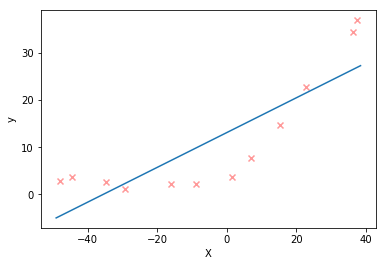

In [321]:
plotDataLin(X, y)

In [322]:
computeGrad(np.ones(2), X, y)  #  expected value =  [-15.30,  598.250 ]

array([ -15.30301567,  598.16741084])

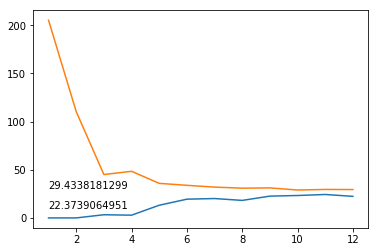

In [323]:
plotLearningCurve(X, y, Xval, yval)

In [324]:
p = 8
poly = PolynomialFeatures(p)

X_poly = poly.fit_transform(X)
X_poly = subOnes(X_poly)

(X_poly,mu,sigma) = featureNormalize(X_poly)
print(mu.shape)

(8,)


(12, 8)
(9,)
(100, 8)


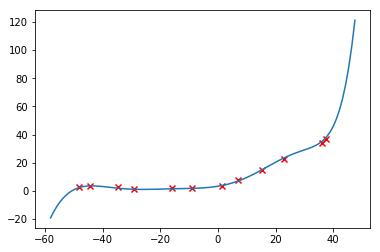

In [325]:
theta = trainLinReg(X_poly, y)
print(X_poly.shape)
print(theta.shape)

#theta = np.array([11.2176,11.2813,14.7554,11.4739,-12.4539,-15.3507,7.6451,3.9019,-4.9419]) # octave fmincg

plt.scatter(X, y, marker='x', color='r')
x_lin = np.linspace(np.min(X) - 10, np.max(X) + 10, 100).reshape(-1,1)
x_lin_poly = poly.fit_transform(x_lin)
x_lin_poly = scaler.transform(subOnes(x_lin_poly))

print(x_lin_poly.shape)

plt.plot(x_lin, addOnes(x_lin_poly) @ theta.reshape(-1,1))
plt.show()

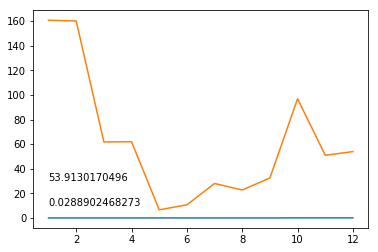

In [326]:
X_poly_val = poly.fit_transform(Xval)
X_poly_val = scale(subOnes(X_poly_val), mu, sigma)
plotLearningCurve(X_poly, y, X_poly_val, yval)

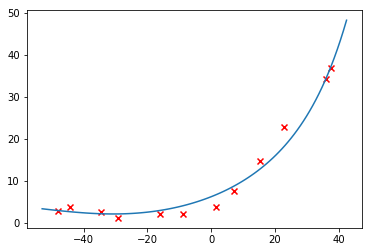

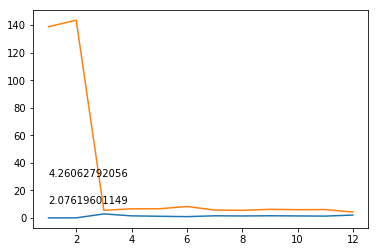

In [327]:
p = 8
lamda = 1

plotPoly(X, y, p, 5,lamda)
plotLearningCurve(X_poly, y, X_poly_val, yval, lamda=lamda)

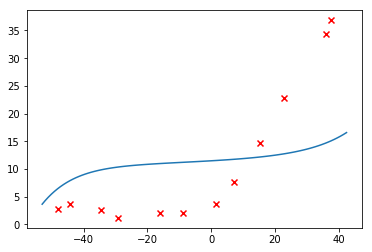

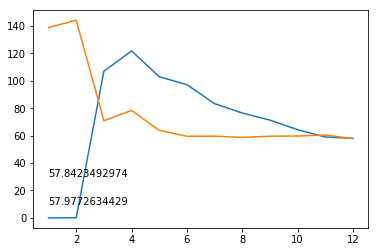

In [328]:
lamda = 100

plotPoly(X, y, p, 5,lamda)
plotLearningCurve(X_poly, y, X_poly_val, yval, lamda=lamda)

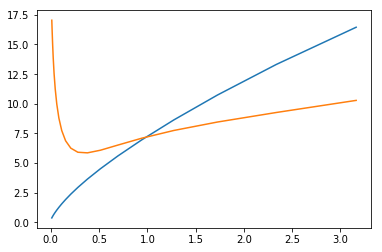

In [339]:
lamda_vec = np.logspace(-2,0.5,20)
(error_train, error_val) = validationCurve(X_poly, y, X_poly_val, yval, lamda_vec=lamda_vec)

plt.plot(lamda_vec, error_train, lamda_vec, error_val)
plt.show()